## 0) Preps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u, astropy.constants as const, astropy.time as Time
from astropy.coordinates import SkyCoord
from astropy.io import fits
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import get_body_heliographic_stonyhurst
import pfsspy
import pfsspy.tracing as tracing

## 1) Getting the daily synoptic map from HMI

### Querying for the daily synoptic map:

In [2]:
timeobs = Time.Time('2014-07-21T00:00:00', scale='utc', format='isot')
dt = Time.TimeDelta((24*3600-1), format='sec')
result = Fido.search(a.Time(timeobs.value, (timeobs+dt).value), a.jsoc.Series('hmi.mrdailysynframe_polfil_720s'), a.jsoc.Notify("your@jsoc.email"))
result

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str23,str7,str9,float64,int64
2014.07.21_12:00:00_TAI,SDO/HMI,HMI_SIDE1,6173.0,2152


### Opening the daily synoptic map:

In [3]:
files = Fido.fetch(result)
hmi_syn_map = fits.open(files[0])[1]

Export request pending. [id=JSOC_20220214_711_X_IN, status=2]
Waiting for 0 seconds...


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO: max_splits keyword was passed and set to 1. [sunpy.net.jsoc.jsoc]
1 URLs found for download. Full request totalling 6MB


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.13file/s]


### Fixing coordinates in header, so they work well with sunpy:

In [4]:
hmi_syn_map.header["CUNIT1"] = 'degree'
hmi_syn_map.header["CUNIT2"] = 'degree'
hmi_syn_map.header["CDELT1"] *= -1
hmi_syn_map.header["CDELT2"] = 180 / np.pi * hmi_syn_map.header["CDELT2"]
t_hmi_syn = hmi_syn_map.header['T_OBS']
t_hmi_syn = Time.Time(t_hmi_syn[:4]+'-'+t_hmi_syn[5:7]+'-'+t_hmi_syn[8:10]+'T'+t_hmi_syn[11:-4], scale='tai')
hmi_syn_map.header["DATE-OBS"] = t_hmi_syn.utc.value

del hmi_syn_map.header["CRDER1"]
del hmi_syn_map.header["CRDER2"]
del hmi_syn_map.header["CSYSER1"]
del hmi_syn_map.header["CSYSER2"]

### Opening the magnetic field map as a sunpy map

In [5]:
hmi_syn_map = sunpy.map.Map(hmi_syn_map.data, hmi_syn_map.header)
print('Data shape: ', hmi_syn_map.data.shape)

Data shape:  (1440, 3600)


### Resampling the magnetic field map to ~0.50 deg = 6 Mm resolution:

In [6]:
hmi_syn_map = hmi_syn_map.resample([720, 360] * u.pix)   ## [longitude, latitude]
print('New shape: ', hmi_syn_map.data.shape)

New shape:  (360, 720)


### Plotting the input field:

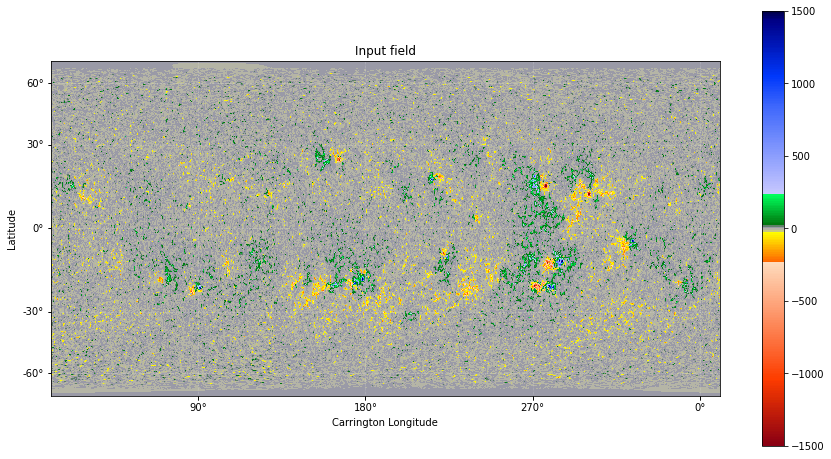

In [7]:
hmi_syn_map.plot_settings['cmap'] = "hmimag"
hmi_syn_map.plot_settings['norm'] = plt.Normalize(-1500, 1500)
fig = plt.figure(0, figsize=(15,8))
ax = plt.subplot(projection=hmi_syn_map.wcs)
hmi_syn_map.plot()
plt.colorbar()
ax.set_title('Input field')
plt.savefig('./01_input_field.jpg', dpi=500)

## 2) Running the extrapolations

### Making the input object for extrapolations with similar resolution (~0.50 deg = 6 Mm) close to the surface:

In [8]:
nrho = 100
rss = 2.5
pfss_in = pfsspy.Input(hmi_syn_map, nrho, rss)

### Calculating the field extrapolation:

In [9]:
pfss_out = pfsspy.pfss(pfss_in)

## 3) Getting the AIA 171 and HMI full-disk maps

In [10]:
t_search = Time.Time(hmi_syn_map.date.value[:-4])
t_search

<Time object: scale='utc' format='isot' value=2014-07-21T11:55:45.000>

### Downloading the full-disk AIA for the time of observation of synoptic map:

In [11]:
dt = Time.TimeDelta(6.5, format='sec')
result_aia = Fido.search(a.Instrument.aia, a.Time((t_search-dt).value, (t_search+dt).value), a.Physobs.intensity, a.Wavelength(171*u.angstrom))
file_aia = Fido.fetch(result_aia)
aia171_map = sunpy.map.Map(file_aia)

Files Downloaded: 100%|██████████| 1/1 [00:09<00:00,  9.41s/file]


Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2014-07-21 11:55:47
Exposure Time,2.000168 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.599489 0.599489] arcsec / pix
Reference Pixel,[2050.139893 2048.969971] pix

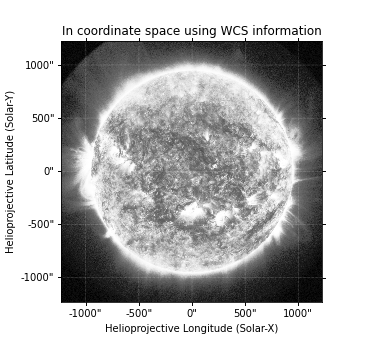
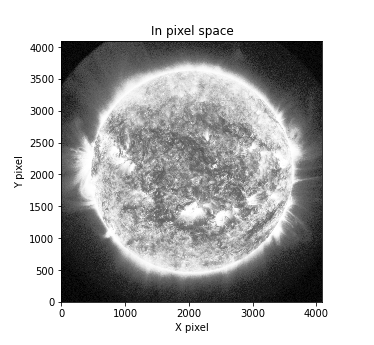
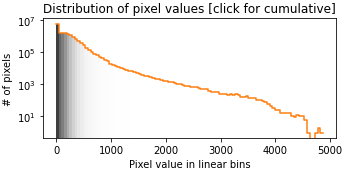
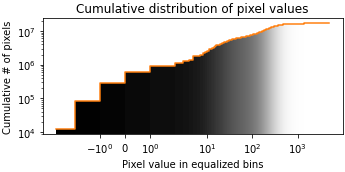

In [12]:
aia171_map

### Downloading the full-disk HMI for the time of observation of synoptic map:

In [13]:
dt = Time.TimeDelta(45/2, format='sec')
result_hmi = Fido.search(a.Time((t_search-dt).value, (t_search+dt).value), a.Instrument.hmi, a.Physobs.los_magnetic_field)
files_hmi = Fido.fetch(result_hmi)
hmi_map = sunpy.map.Map(files_hmi[0])

Files Downloaded: 100%|██████████| 1/1 [00:05<00:00,  5.30s/file]


### Reprojecting HMI map onto AIA coordinate grid and setting the color map for plots:

In [14]:
hmi_map.plot_settings['cmap'] = "hmimag"
hmi_map.plot_settings['norm'] = plt.Normalize(-1500, 1500)
hmi_map = hmi_map.reproject_to(aia171_map.wcs)

Observatory,
Instrument,
Detector,
Measurement,Unknown
Wavelength,Unknown
Observation Date,2014-07-21 11:55:47
Exposure Time,Unknown
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.00016652 0.00016652] deg / pix
Reference Pixel,[2050.139893 2048.969971] pix

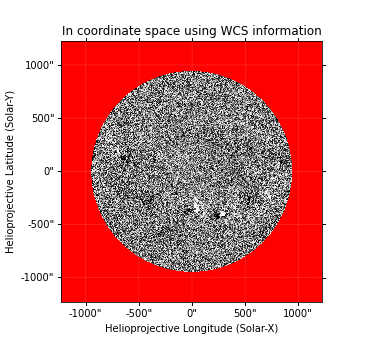
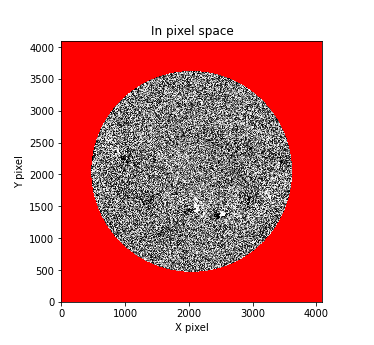
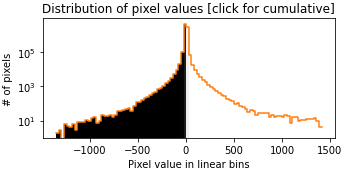
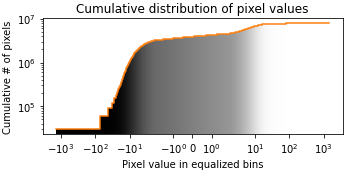

In [15]:
hmi_map

## 4) Making seeds and tracing the field lines

### Making seeds for tracing field lines over the region of interest:

Seeds are set in the 3d coordinate system of the input magnetic field map.

In [16]:
r = 1.015 * const.R_sun  ## starting some 10 Mm above the photosphere
lat = np.linspace(-18, -24, 4)*u.deg
lon = np.linspace(82, 92, 4)*u.deg
    
lon, lat = np.meshgrid(lon, lat)
lat, lon = lat.ravel(), lon.ravel()
seeds = SkyCoord(radius=r, lon=lon, lat=lat, frame=hmi_syn_map.coordinate_frame)

### Tracing the magnetic field lines:

In [17]:
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

/home/nikki/venv3/lib/python3.8/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'


## 5) Plotting seeds and field lines on synoptic map

### Plotting the seeds on the input magnetic field map:

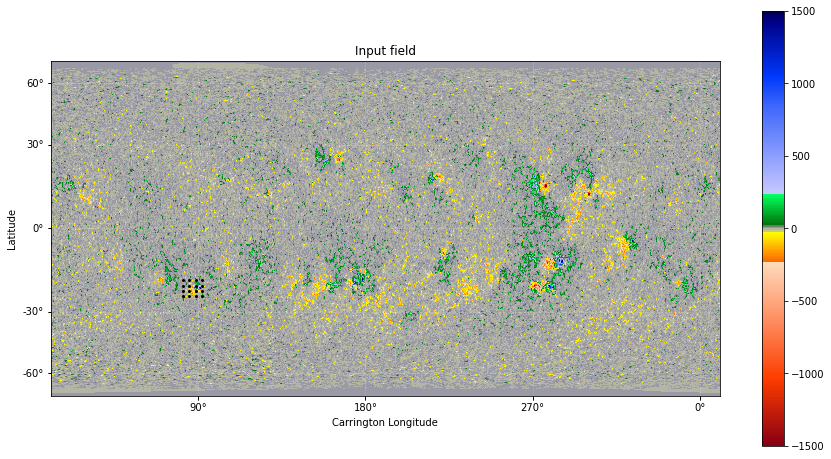

In [18]:
fig = plt.figure(1, figsize=(15,8))
ax0 = plt.subplot(projection=pfss_in.map)
hmi_syn_map.plot(ax0)
plt.colorbar()
ax0.plot_coord(seeds, color='black', marker='o', markersize=2, linewidth=0)
ax0.set_title('Input field')
plt.savefig('./02_input_field_seeds.jpg', dpi=500)

### Plotting the field lines on the input magnetic field map:

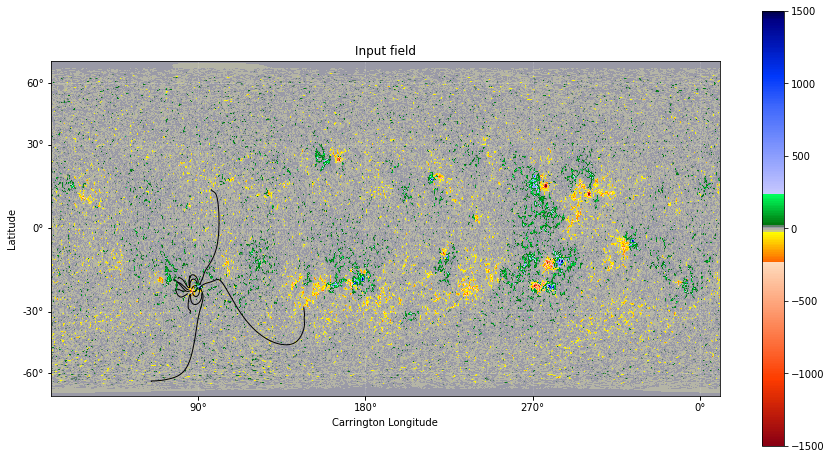

In [19]:
fig = plt.figure(3, figsize=(15,8))
ax0 = plt.subplot(projection=pfss_in.map)
hmi_syn_map.plot(ax0)
plt.colorbar()
ax0.set_title('Input field')
for fline in flines:
    coords = fline.coords
    if np.size(coords) != 0:
        color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
        ax0.plot_coord(fline.coords, color=color, linewidth=1)
plt.savefig('./03_input_field_lines.jpg', dpi=500)

## 6) Plotting seeds and field lines on full-disk maps

### <span style="color:red"> Here things don't work properly, because seeds and lines are obviously not above the AR. </span>

### Plotting the seeds on the full-disk maps:

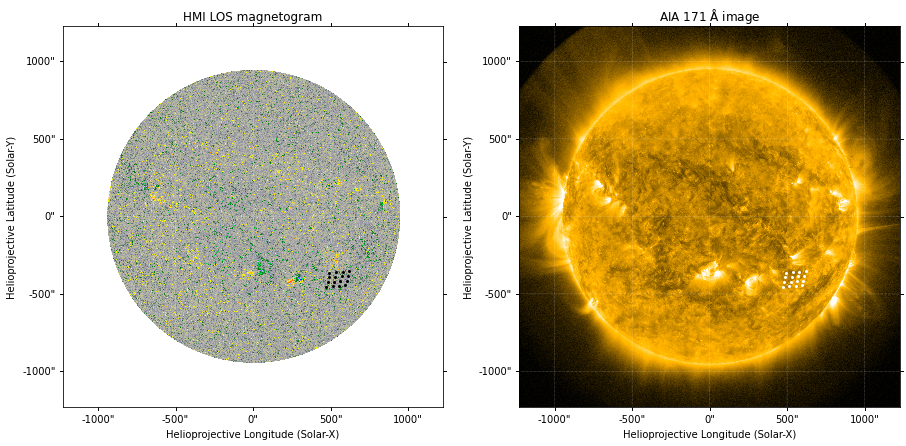

In [20]:
fig = plt.figure(2, figsize=(15,8))
ax1 = plt.subplot(1,2,1, projection=hmi_map)
hmi_map.plot(axes=ax1)
ax1.plot_coord(seeds, color='black', marker='o', markersize=2, linewidth=0)
ax1.set_title('HMI LOS magnetogram')
ax2 = plt.subplot(1,2,2, projection=aia171_map)
aia171_map.plot(axes=ax2, clip_interval=(1, 99.9)*u.percent)
ax2.plot_coord(seeds, color='white', marker='o', markersize=2, linewidth=0)
ax2.set_title(r'$\mathrm{AIA\ 171\ \AA\ image}$')
plt.savefig('./04_hmi_and_aia171_seeds.jpg', dpi=500)

### Plotting the field lines on the full-disk maps:

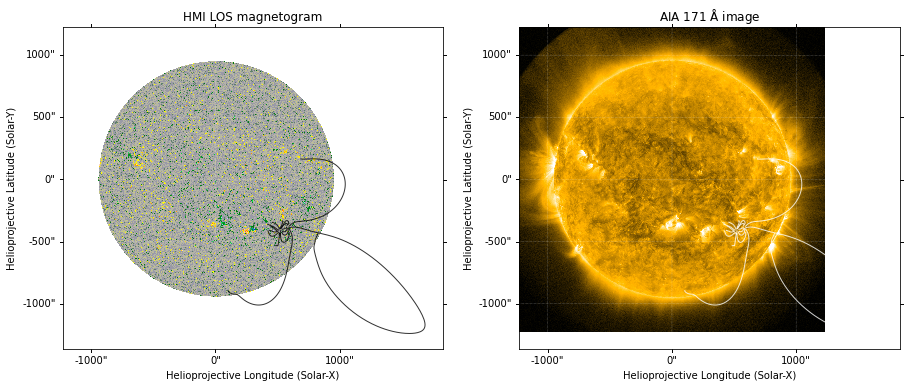

In [21]:
fig = plt.figure(4, figsize=(15,8))
ax1 = plt.subplot(1,2,1, projection=hmi_map)
hmi_map.plot(axes=ax1)
ax2 = plt.subplot(1,2,2, projection=aia171_map)
aia171_map.plot(axes=ax2, clip_interval=(1, 99.9)*u.percent)
ax1.set_title('HMI LOS magnetogram')
ax2.set_title(r'$\mathrm{AIA\ 171\ \AA\ image}$')
for fline in flines:
    coords = fline.coords
    if np.size(coords) != 0:
        color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
        ax1.plot_coord(coords, alpha=0.8, linewidth=1, color=color)
        color = {0: 'white', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
        ax2.plot_coord(coords, alpha=0.8, linewidth=1, color=color)
plt.savefig('./05_hmi_and_aia171_lines.jpg', dpi=500)

## 6) Trying instead to reproject the synoptic map on the full-disk coordinate system:

### Reprojecting the synoptic map and seeds on the full-disk map coordinate system:

In [22]:
hmi_syn_map_repr = hmi_syn_map.reproject_to(aia171_map.wcs)

In [23]:
seeds_repr = seeds.transform_to(aia171_map.coordinate_frame)

### Plotting the synoptic map in full-disk representation:

### <span style="color:red"> This looks nice, but the image is obviously shifted when compared with the full-disk map from HMI above. </span>

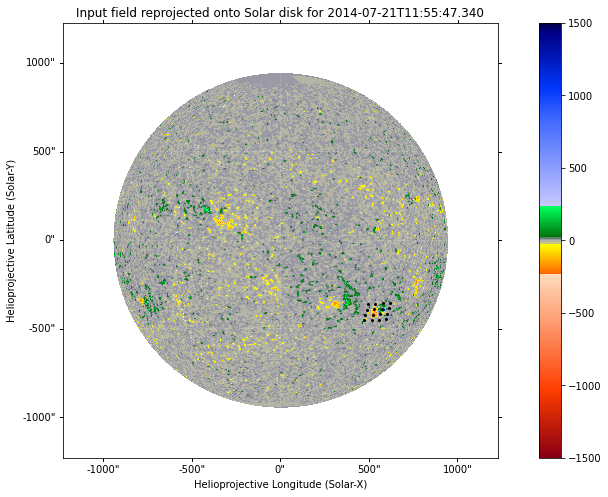

In [24]:
fig = plt.figure(1, figsize=(15,8))
ax0 = plt.subplot(projection=aia171_map)
hmi_syn_map_repr.plot(ax0)
plt.colorbar()
ax0.plot_coord(seeds_repr, color='black', marker='o', markersize=2, linewidth=0)
ax0.set_title('Input field reprojected onto Solar disk for %s' % aia171_map.date)
plt.savefig('./06_input_field_full-disk_seeds.jpg', dpi=500)